In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from pycaret.classification import *
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from pprint import pprint

from IPython.display import clear_output

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 20)

In [2]:
data = pd.read_excel('data/consolidated.xlsx')

---
## EDA

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3165 entries, 0 to 3164
Data columns (total 46 columns):
 #   Column                                                      Non-Null Count  Dtype         
---  ------                                                      --------------  -----         
 0   client_id                                                   3165 non-null   int64         
 1   loan_amount                                                 3165 non-null   float64       
 2   date_of_disbursement                                        3165 non-null   datetime64[ns]
 3   date_of_closure_based_on_contract                           3165 non-null   datetime64[ns]
 4   duration_at_disbursement_months                             3165 non-null   int64         
 5   interest_rate                                               3165 non-null   float64       
 6   max_dpd_3_year                                              3165 non-null   int64         
 7   cmltv_days              

---
## Feature selection

In [4]:
# Creating target columns #
target = 'cmltv_90_bad'

data[target] = (data['cmltv_days'] >= 90).astype(int)
print(data[target].value_counts())

0    2622
1     543
Name: cmltv_90_bad, dtype: int64


In [5]:
# Choosing only Closed loans & Active loans that are already bad #
data_closed_or_bad = data[(data['status_of_loan'] == 'Active') & (data[target] == 1) | (data['status_of_loan'] != 'Active')]
data_closed_or_bad.shape

(2700, 47)

In [6]:
data_closed_or_bad.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2700 entries, 6 to 3164
Data columns (total 47 columns):
 #   Column                                                      Non-Null Count  Dtype         
---  ------                                                      --------------  -----         
 0   client_id                                                   2700 non-null   int64         
 1   loan_amount                                                 2700 non-null   float64       
 2   date_of_disbursement                                        2700 non-null   datetime64[ns]
 3   date_of_closure_based_on_contract                           2700 non-null   datetime64[ns]
 4   duration_at_disbursement_months                             2700 non-null   int64         
 5   interest_rate                                               2700 non-null   float64       
 6   max_dpd_3_year                                              2700 non-null   int64         
 7   cmltv_days              

In [7]:
data['age']

0       51
1       59
2       45
3       49
4       56
        ..
3160    47
3161    46
3162    39
3163    51
3164    36
Name: age, Length: 3165, dtype: int64

In [8]:
cat_feats = [
    'employment_sphere',
    'gender',
    'family_status',
    'type_of_product',
    'emirates',
    'employment_level',
    'location',
    'coborrower',
    'collateral',
    
    # Application features #
    'product_type',
    'residential_status',
    'is_existing_product_at_bank_delinquent',
    'employer_category',
    'salary_transfer_y_n'
]
num_feats = [
    'loan_amount',
    'duration_at_disbursement_months',
    'interest_rate',
    'age',
    'monthly_income_aed',
    'work_experience',
    'presence_of_housing',
    'presence_of_car',
    'quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi',
    'dsr',
    'aecb',
    # Application features #
    'number_of_years_in_uae',
    'has_account_with_the_bank_y_n',
    'last_six_months_average_account_balance',
    'number_of_loans_products_at_bank_with_cbi',
    'loan_to_value_ratio'
]

In [22]:
# Feature encoding #
# dummies = pd.get_dummies( data_closed_or_bad[cat_feats] )

encoded_data = data_closed_or_bad[ num_feats+cat_feats+[target] ].copy()
# encoded_data = pd.concat([encoded_data,dummies],axis=1)

# num_feats = list(encoded_data.drop(target,axis=1).columns)
# cat_feats.clear()

In [23]:
for i in encoded_data.corr()[target].index :
    print(i, encoded_data.corr()[target][i])

loan_amount -0.06421448964836463
duration_at_disbursement_months 0.056878935855664114
interest_rate 0.16975616883784322
age -0.0649196192392334
monthly_income_aed -0.1609516963563084
work_experience -0.10980991900230633
presence_of_housing -0.08438807747410433
presence_of_car -0.09075236108840577
quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi -0.07080723160625646
dsr 0.1458578947689019
aecb -0.1945558640094857
number_of_years_in_uae -0.1695462023524424
has_account_with_the_bank_y_n 0.005491513292854259
last_six_months_average_account_balance -0.10647693337305404
number_of_loans_products_at_bank_with_cbi 0.44856834010199403
loan_to_value_ratio -0.07889285663589823
cmltv_90_bad 1.0


/tmp/ipykernel_21396/2244515525.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  for i in encoded_data.corr()[target].index :
/tmp/ipykernel_21396/2244515525.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(i, encoded_data.corr()[target][i])


In [32]:
for col in cat_feats:
    encoded_data[col] = encoded_data[col].fillna("NaN")
    
encoded_data.rename({'quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi':'prior_loans_at_cbi'},axis=1,inplace=True)

---
## Modeling

In [33]:
X, y = encoded_data.drop(target,axis=1), encoded_data[target]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, train_size=0.8, random_state=10, stratify=encoded_data[target])

print( X_train.shape )
print( X_test.shape )

(2160, 30)
(540, 30)


In [ ]:
import optuna
from optuna.samplers import TPESampler
from catboost.utils import eval_metric
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import roc_auc_score, make_scorer

seed = 10

def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1),
        'depth': trial.suggest_int('depth', 1, 5),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 20),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bernoulli']),
        'iterations': trial.suggest_int('iterations', 50, 200)
    }
    model = CatBoostClassifier(**params, random_seed=seed, cat_features=cat_feats)
    model.fit(X_train, y_train, verbose=0)
    kf = KFold(n_splits=5, shuffle=True, random_state=10)
    roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
    scores = cross_val_score(model, X, y, scoring=roc_auc_scorer, cv=kf, verbose=0)
    return np.mean(scores)

study = optuna.create_study()
study.optimize(objective, n_trials=50)

In [39]:
# 30 days best hyperparameters
best_params_30 = study.best_params

best_params_30

{'learning_rate': 0.050560475589369415,
 'depth': 1,
 'l2_leaf_reg': 19.939692341912078,
 'bootstrap_type': 'Bernoulli',
 'iterations': 52}

In [40]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier(
    **best_params_30,
    random_seed = seed,
    cat_features = cat_feats
)

clf.fit(X_train, y_train,
        verbose=False
)

---
## Metrics

In [41]:
X_test['prediction_score_1'] = clf.predict_proba(X_test)[:, 1]
X_train['prediction_score_1'] = clf.predict_proba(X_train)[:, 1]

X_test[target] = y_test.copy()
X_train[target] = y_train.copy()

# get performance metrics
results_model = pd.DataFrame(columns=['Sample size', 'Train size', 'Test size', 'Total good', 'Total bad', 'Test good', 'Test bad',
                                'Threshold', 'Accuracy', 'Train AUC', 'Test AUC', 'Train Gini', 'Test Gini',
                                'TN', 'FP', 'FN', 'TP', 'Real NPL', 'Model NPL', 'Approval rate', 'Bad found', 'Good found'])

for thres in [x / 100 for x in range(10, 50, 5)]:
    X_test['prediction_label'] = (X_test['prediction_score_1'] > thres).astype(int)
    X_train['prediction_label'] = (X_train['prediction_score_1'] > thres).astype(int)

    samples = X_train.shape[0] + X_test.shape[0]
    train_size = X_train.shape[0]
    test_size = X_test.shape[0]
    total_good = X_train[target].value_counts()[0] + X_test[target].value_counts()[0]
    total_bad = X_train[target].value_counts()[1] + X_test[target].value_counts()[1]
    test_good = X_test[target].value_counts()[0]
    test_bad = X_test[target].value_counts()[1]
    
    accuracy = accuracy_score(X_test[target], X_test['prediction_label'])
    auc_test = roc_auc_score(X_test[target], X_test['prediction_score_1'])
    auc_train = roc_auc_score(X_train[target], X_train['prediction_score_1'])
    gini_test = 2*auc_test-1
    gini_train = 2*auc_train-1

    tn, fp, fn, tp = confusion_matrix(X_test[target], X_test['prediction_label']).ravel()
    real_npl = round((tp + fn)/(tn + fp + fn + tp), 4) * 100
    model_npl = round(fn/(tn+fn), 4) * 100
    app_rate = round((fn + tn)/(tn + fp + fn + tp), 3) * 100
    bad_corr = round(tp/(fn+tp), 3) * 100
    good_corr = round(tn/(fp+tn), 3) * 100
    
    row = [samples, train_size, test_size, total_good, total_bad, test_good, test_bad,
           thres, accuracy, auc_train, auc_test, gini_train, gini_test, tn, fp, fn, tp, real_npl, model_npl, app_rate, bad_corr, good_corr]
    results_model.loc[len(results_model)] = row
    
    
X_test.drop(['prediction_score_1','prediction_label',target],axis=1,inplace=True)
X_train.drop(['prediction_score_1','prediction_label',target],axis=1,inplace=True)

results_model

/tmp/ipykernel_6090/1620108703.py:32: RuntimeWarning: invalid value encountered in long_scalars
  model_npl = round(fn/(tn+fn), 4) * 100


,Sample size,Train size,Test size,Total good,Total bad,Test good,Test bad,Threshold,Accuracy,Train AUC,Test AUC,Train Gini,Test Gini,TN,FP,FN,TP,Real NPL,Model NPL,Approval rate,Bad found,Good found
0,2700.0,2160.0,540.0,2157.0,543.0,431.0,109.0,0.10,0.201852,0.833154,0.861257,0.666307,0.722514,0.0,431.0,0.0,109.0,20.19,NaN,0.0,100.0,0.0
1,2700.0,2160.0,540.0,2157.0,543.0,431.0,109.0,0.15,0.250000,0.833154,0.861257,0.666307,0.722514,26.0,405.0,0.0,109.0,20.19,0.00,4.8,100.0,6.0
2,2700.0,2160.0,540.0,2157.0,543.0,431.0,109.0,0.20,0.740741,0.833154,0.861257,0.666307,0.722514,310.0,121.0,19.0,90.0,20.19,5.78,60.9,82.6,71.9
3,2700.0,2160.0,540.0,2157.0,543.0,431.0,109.0,0.25,0.877778,0.833154,0.861257,0.666307,0.722514,407.0,24.0,42.0,67.0,20.19,9.35,83.1,61.5,94.4
4,2700.0,2160.0,540.0,2157.0,543.0,431.0,109.0,0.30,0.885185,0.833154,0.861257,0.666307,0.722514,419.0,12.0,50.0,59.0,20.19,10.66,86.9,54.1,97.2
5,2700.0,2160.0,540.0,2157.0,543.0,431.0,109.0,0.35,0.877778,0.833154,0.861257,0.666307,0.722514,426.0,5.0,61.0,48.0,20.19,12.53,90.2,44.0,98.8
6,2700.0,2160.0,540.0,2157.0,543.0,431.0,109.0,0.40,0.861111,0.833154,0.861257,0.666307,0.722514,428.0,3.0,72.0,37.0,20.19,14.40,92.6,33.9,99.3
7,2700.0,2160.0,540.0,2157.0,543.0,431.0,109.0,0.45,0.848148,0.833154,0.861257,0.666307,0.722514,430.0,1.0,81.0,28.0,20.19,15.85,94.6,25.7,99.8


Text(0.5, 1.0, 'Feature Importance')

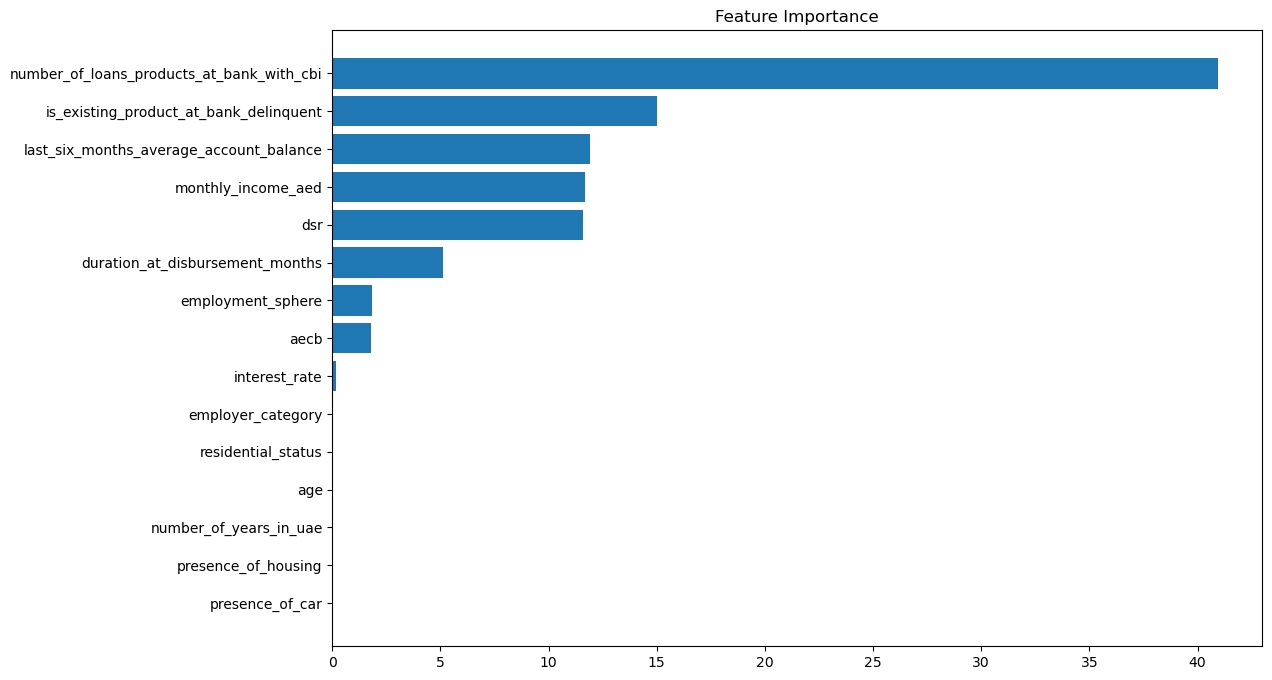

In [42]:
feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[-15:]
fig = plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

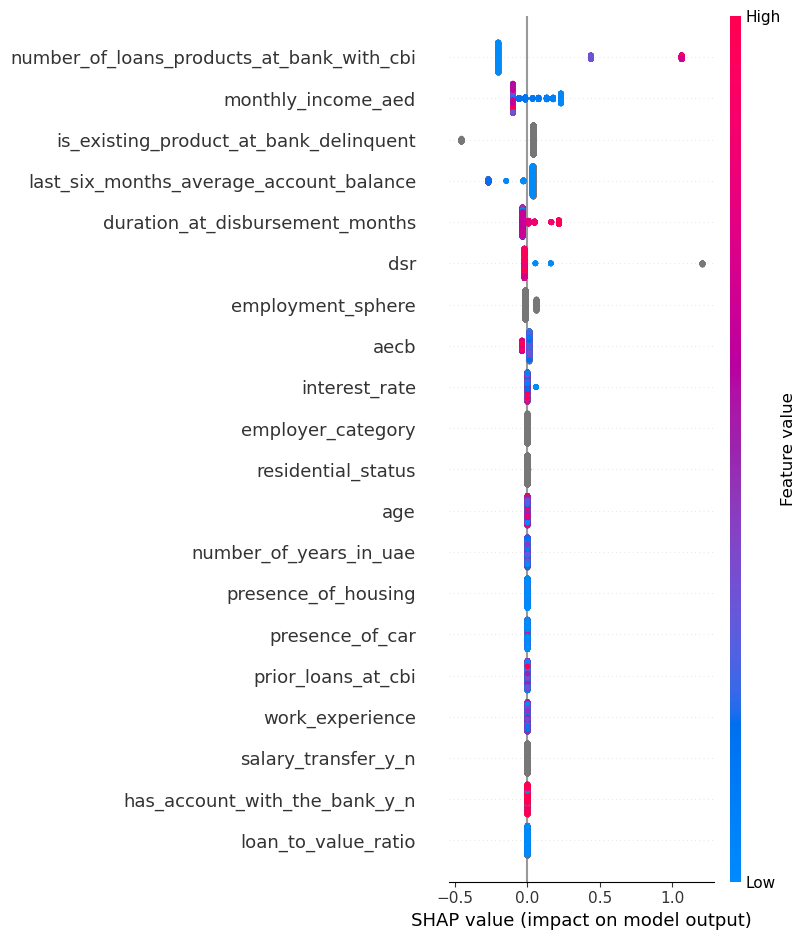

In [43]:
import shap
explainer = shap.TreeExplainer(clf)
clear_output()

shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)